In [1]:
from matplotlib import colors as m_colors
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from yaml import load as load_yaml, FullLoader

from dataset import KIDataset, train_test_split_stratified
from models.inceptiontime import LitInceptionTimeModel
from processor.processor import Leif
from utils.const import SEED
from utils.data import binarize
from utils.misc import set_random_state
from utils.path import config_path, checkpoint_path

set_random_state(SEED)
!conda activate eyetrackpdc

# Data parameters
BINARY_CLF = True

# Dataloader Parameters
BATCH_SIZE_SEGMENTS = 256

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\neptune\internal\backends\hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\loggers\neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


### Load Configs

In [2]:
with open(config_path.joinpath('leif.yaml')) as reader:
    processor_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('transformer.yaml')) as reader:
    transformer_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('inception.yaml')) as reader:
    inception_config = load_yaml(reader, Loader=FullLoader)
with open(config_path.joinpath('neptune.yaml')) as reader:
    neptune_config = load_yaml(reader, Loader=FullLoader)

### Initialize the processor

In [3]:
# Configure processor
processor = Leif(processor_config)

### Prepare Data (segments)

In [4]:
# Initialize Datasets
train_val_ds = KIDataset(data_processor=processor, train=True, bundle_as_trials=False, use_triplets=True)
train_ds, val_ds = train_test_split_stratified(train_val_ds, test_size=0.2)
test_ds = KIDataset(data_processor=processor, train=False, bundle_as_trials=False, use_triplets=True)

# Binarize dataset after split to make sure split is stratified w.r.t all three classes
if BINARY_CLF:
    for ds in [train_ds, val_ds, test_ds]:
        binarize(ds)

# Initialize Dataloaders
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE_SEGMENTS,
                      sampler=ImbalancedDatasetSampler(train_ds, callback_get_label=lambda item: item.y))
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE_SEGMENTS)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE_SEGMENTS)

loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-train.pth
loaded dataset from C:\Users\hejpa\Documents\GitHub\eye-track-pdc\data\ki\tmp\ki-HC,PD_OFF,PD_ON-seg-test.pth


### Initialize Models

In [5]:
inception_time = LitInceptionTimeModel(**inception_config)
tsne = TSNE(n_components=2, perplexity=30)
pca = PCA(n_components=50)

### Train InceptionTime using Triplet Loss

In [7]:
trainer = Trainer(accelerator='auto',
                  max_epochs=100,
                  logger=NeptuneLogger(log_model_checkpoints=True, **neptune_config),
                  callbacks=[LearningRateMonitor(),
                             ModelCheckpoint(dirpath=checkpoint_path, monitor='val_loss', every_n_epochs=5),
                             ],  #EarlyStopping(monitor='val_loss', patience=20)],
                  log_every_n_steps=1)

# Run learning rate finder
#lr_finder = trainer.tuner.lr_find(inception_time, train_dl, val_dl, early_stop_threshold=None)
#
## Plot with
#fig = lr_finder.plot(suggest=True)
#fig.show()
#
## Pick point based on plot, or get suggestion
#new_lr = lr_finder.suggestion()
#print(new_lr)

trainer.fit(inception_time, train_dl, val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\hejpa\Documents\GitHub\eye-track-pdc\checkpoint exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | blocks  | Sequential        | 56.8 K
1 | linear  | Linear            | 4.2 K 
2 | loss_fn | TripletMarginLoss | 0     
----------------------------------------------
61.1 K    Trainable params
0         Non-trainable params
61.1 K    Total params
0.244     Total estimated model params size (MB)


https://app.neptune.ai/KTH/EyeTrackPDC/e/PDC-3


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Error occurred during asynchronous operation processing: Cannot upload file C:\Users\hejpa\Documents\GitHub\eye-track-pdc\checkpoint\epoch=44-step=180.ckpt: Path not found or is a not a file.
Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=44-step=180: Attribute does not exist


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Visualize embeddings for validation set

In [8]:
# Use the best model in terms of validation loss
inception_time = LitInceptionTimeModel.load_from_checkpoint(checkpoint_path.joinpath('epoch=54-step=220.ckpt'))

train_ds.use_triplets = False
val_ds.use_triplets = False
complete_train_set = next(iter(DataLoader(train_ds,
                                          batch_size=len(train_ds),
                                          sampler=ImbalancedDatasetSampler(train_ds,
                                                                           callback_get_label=lambda item: item.y))))
complete_val_set = next(iter(DataLoader(val_ds, batch_size=len(val_ds))))

embeddings = inception_time(complete_val_set.x)

proj = pca.fit_transform(embeddings.detach(), complete_val_set.y)
manifold = tsne.fit_transform(proj)

C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\hejpa\Anaconda3\envs\eyetrackpdc\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


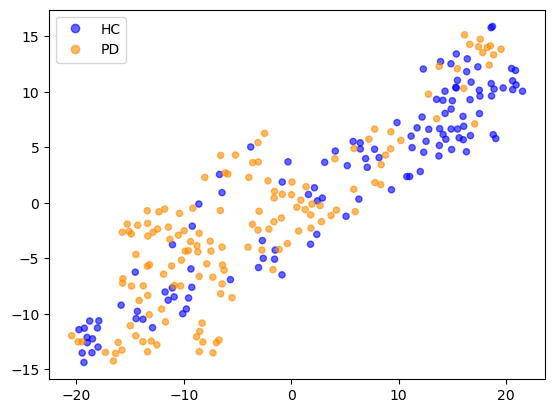

In [9]:
labels = ['HC', 'PD']
colors = ['blue', 'darkorange']
cmap = m_colors.ListedColormap(colors)
scatter = plt.scatter(manifold[:, 0], manifold[:, 1], c=complete_val_set.y, s=20, alpha=0.6, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()